Speech Emotion Recognition - Classical ML Training Script (with Gender + Clustering)

- Extracts MFCC-based features from RAVDESS-style dataset
- Trains multiple classical ML models for EMOTION
- Trains a RandomForest model for GENDER
- Performs unsupervised clustering (DBSCAN + Hierarchical)
- Saves:
    - ser_scaler.joblib
    - ser_model_<name>.joblib
    - ser_model_best.joblib
    - ser_model_gender.joblib
    - model_results.csv
    - features_emotion_gender.npz  (X, y_emotion, y_gender)
"""


In [ ]:
# Cell 1: Imports & basic config

import os
from glob import glob
import numpy as np
import pandas as pd
import librosa
import joblib
import matplotlib.pyplot as plt
import seaborn as  sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram

sns.set_theme(style="whitegrid", palette="viridis", font_scale=1.1)

BASE_DIR = r"C:\Users\User\Desktop\ML_finalprojectfile"
EXTRACT_DIR = os.path.join(BASE_DIR, "Audio_Song_Actors_01-24")
DATA_ZIP = os.path.join(BASE_DIR, "Audio_Song_Actors_01-24.zip")  
DBSCAN_VIS_PATH = os.path.join(BASE_DIR, "dbscan_vis.npz")
HIER_VIS_PATH = os.path.join(BASE_DIR, "hierarchical_vis.npz")
SCALER_PATH = os.path.join(BASE_DIR, "ser_scaler.joblib")
BEST_MODEL_PATH = os.path.join(BASE_DIR, "ser_model_best.joblib")
GENDER_MODEL_PATH = os.path.join(BASE_DIR, "ser_model_gender.joblib")
RESULTS_CSV_PATH = os.path.join(BASE_DIR, "model_results.csv")

EMOTIONS = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised",
}
EMOTIONS

{'01': 'neutral',
 '02': 'calm',
 '03': 'happy',
 '04': 'sad',
 '05': 'angry',
 '06': 'fearful',
 '07': 'disgust',
 '08': 'surprised'}

In [ ]:
#Dataset prep + feature extraction

def ensure_dataset():
    if os.path.isdir(EXTRACT_DIR):
        print(f"Using folder: {EXTRACT_DIR}")
        return
    if os.path.exists(DATA_ZIP):
        print("Extracting zip...")
        with ZipFile(DATA_ZIP, "r") as z:
            z.extractall(EXTRACT_DIR)
        print("Done.")
    else:
        raise FileNotFoundError("Dataset zip/folder not found.")

def parse_emotion_from_filename(path: str) -> str:
    base = os.path.basename(path)
    parts = base.split("-")
    if len(parts) > 2:
        return EMOTIONS.get(parts[2], "unknown")
    return "unknown"

def parse_gender_from_path(path: str) -> str:
    # RAVDESS convention: Actor_01, Actor_02, ...
    parts = path.replace("\\", "/").split("/")
    actor_part = None
    for p in parts:
        if p.startswith("Actor_"):
            actor_part = p
            break
    if actor_part is None:
        return "unknown"
    try:
        actor_id = int(actor_part.split("_")[1])
    except Exception:
        return "unknown"
    return "male" if actor_id % 2 == 1 else "female"

def extract_features_from_array(y, sr=22050, n_mfcc=20):
    # pad or repeat to 1 second
    if len(y) < sr:
        y = np.tile(y, int(np.ceil(sr / len(y))))[:sr]

    # simple normalisation
    if np.max(np.abs(y)) > 0:
        y = y / np.max(np.abs(y))

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs_delta = librosa.feature.delta(mfccs)
    mfccs_delta2 = librosa.feature.delta(mfccs, order=2)

    feat = np.concatenate([
        mfccs.mean(axis=1),
        mfccs.std(axis=1),
        mfccs_delta.mean(axis=1),
        mfccs_delta.std(axis=1),
        mfccs_delta2.mean(axis=1),
        mfccs_delta2.std(axis=1),
    ])
    return feat


def extract_features_from_file(path, sr_target=22050, n_mfcc=20):
    y, sr = librosa.load(path, sr=sr_target)
    return extract_features_from_array(y, sr=sr_target, n_mfcc=n_mfcc)

def load_dataset_with_augmentation():
    wav_files = sorted(glob(os.path.join(EXTRACT_DIR, "**", "*.wav"), recursive=True))
    print(f"Found {len(wav_files)} wav files")

    X, y_emotion, y_gender = [], [], []
    class_counts = {v: 0 for v in EMOTIONS.values()}

    for f in wav_files:
        emo = parse_emotion_from_filename(f)
        gen = parse_gender_from_path(f)
        if emo not in EMOTIONS.values() or gen not in ("male", "female"):
            continue

        # original
        feat = extract_features_from_file(f)
        X.append(feat)
        y_emotion.append(emo)
        y_gender.append(gen)
        class_counts[emo] += 1

        # simple augmentation for low-count emotions
        if class_counts[emo] < 200:
            y, sr = librosa.load(f, sr=22050)
            for steps in (+2, -2):
                y_shifted = librosa.effects.pitch_shift(y, sr=sr, n_steps=steps)
                feat_aug = extract_features_from_array(y_shifted, sr=sr)
                X.append(feat_aug)
                y_emotion.append(emo)
                y_gender.append(gen)

    X = np.array(X)
    y_emotion = np.array(y_emotion)
    y_gender = np.array(y_gender)

    print("Emotion counts:\n", pd.Series(y_emotion).value_counts())
    print("\nGender counts:\n", pd.Series(y_gender).value_counts())
    return X, y_emotion, y_gender

ensure_dataset()
X, y_emotion, y_gender = load_dataset_with_augmentation()


Using folder: C:\Users\User\Desktop\ML_finalprojectfile\Audio_Song_Actors_01-24
Found 1012 wav files
Emotion counts:
 calm       552
happy      552
angry      552
sad        552
fearful    552
neutral    276
Name: count, dtype: int64

Gender counts:
 male      1584
female    1452
Name: count, dtype: int64


In [3]:
# Cell 3: Train/test split + scaling

X_train, X_test, y_train_em, y_test_em = train_test_split(
    X, y_emotion, test_size=0.2, stratify=y_emotion, random_state=42
)

_, _, y_train_gen, y_test_gen = train_test_split(
    X, y_gender, test_size=0.2, stratify=y_gender, random_state=42
)

scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

joblib.dump(scaler, SCALER_PATH)
print("Scaler saved:", SCALER_PATH)


Scaler saved: C:\Users\User\Desktop\ML_finalprojectfile\ser_scaler.joblib


In [4]:
# Cell 4: Train multiple classical ML classifiers for EMOTION

classifiers = {
    "svm_rbf": SVC(kernel="rbf", C=5.0, gamma="scale", probability=True),
    "random_forest": RandomForestClassifier(n_estimators=120, random_state=42),
}


results = []
best_name, best_model, best_acc = None, None, -1.0

for name, clf in classifiers.items():
    print(f"\n=== Training emotion model: {name} ===")
    clf.fit(X_train_s, y_train_em)
    y_pred = clf.predict(X_test_s)
    acc = accuracy_score(y_test_em, y_pred)
    rep = classification_report(y_test_em, y_pred, output_dict=True, zero_division=0)
    macro = rep["macro avg"]

    results.append({
        "model": name,
        "accuracy": acc,
        "precision_macro": macro["precision"],
        "recall_macro": macro["recall"],
        "f1_macro": macro["f1-score"],
    })

    joblib.dump(clf, os.path.join(BASE_DIR, f"ser_model_{name}.joblib"))
    print("Accuracy:", round(acc, 3))

    if acc > best_acc:
        best_acc = acc
        best_name = name
        best_model = clf

joblib.dump(best_model, BEST_MODEL_PATH)
print(f"\nBest model: {best_name}, acc={best_acc:.3f}")

results_df = pd.DataFrame(results)
results_df.to_csv(RESULTS_CSV_PATH, index=False)
results_df
EVAL_DATA_PATH = os.path.join(BASE_DIR, "eval_data_emotion.npz")

np.savez(
    EVAL_DATA_PATH,
    X_test_s=X_test_s,
    y_test_em=y_test_em,
    labels=np.unique(y_emotion),
)
print("Saved evaluation data to:", EVAL_DATA_PATH)




=== Training emotion model: svm_rbf ===
Accuracy: 0.854

=== Training emotion model: random_forest ===
Accuracy: 0.707

Best model: svm_rbf, acc=0.854
Saved evaluation data to: C:\Users\User\Desktop\ML_finalprojectfile\eval_data_emotion.npz


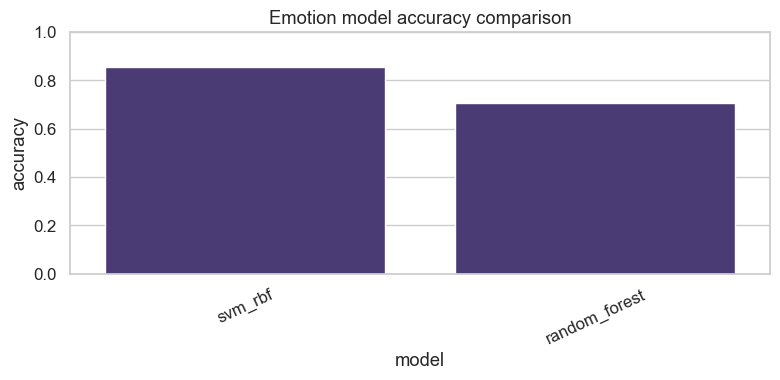

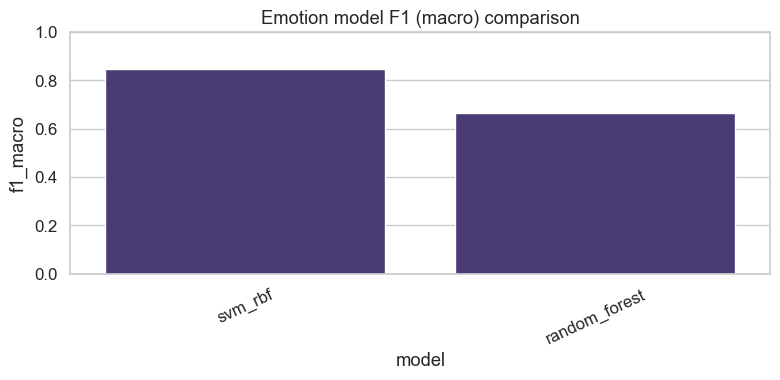

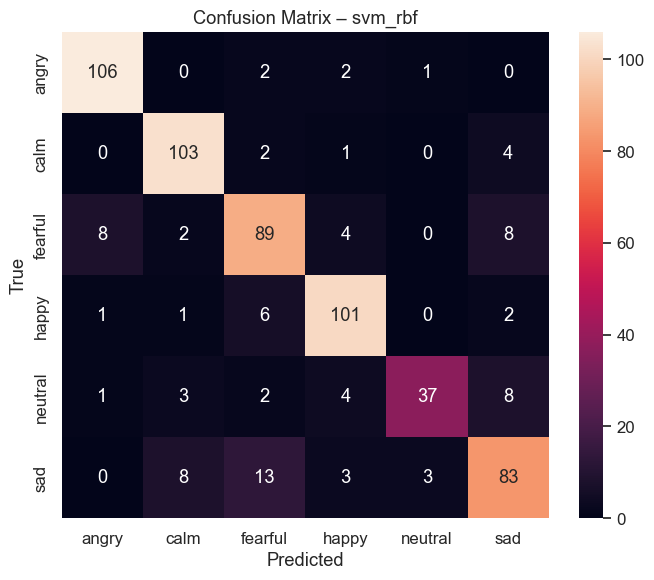

In [5]:
# Cell 5: Visualizations – model comparison

plt.figure(figsize=(8,4))
sns.barplot(data=results_df, x="model", y="accuracy")
plt.title("Emotion model accuracy comparison")
plt.xticks(rotation=25)
plt.ylim(0,1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(data=results_df, x="model", y="f1_macro")
plt.title("Emotion model F1 (macro) comparison")
plt.xticks(rotation=25)
plt.ylim(0,1)
plt.tight_layout()
plt.show()

# Confusion matrix for best model
y_best_pred = best_model.predict(X_test_s)
cm = confusion_matrix(y_test_em, y_best_pred, labels=sorted(np.unique(y_emotion)))

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=sorted(np.unique(y_emotion)),
            yticklabels=sorted(np.unique(y_emotion)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix – {best_name}")
plt.tight_layout()
plt.show()


In [6]:
# Cell 6: Gender classifier (RandomForest)

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(
    X, y_gender, test_size=0.2, stratify=y_gender, random_state=42
)

X_train_gs = scaler.transform(X_train_g)
X_test_gs  = scaler.transform(X_test_g)

gender_clf = RandomForestClassifier(n_estimators=150, random_state=42)
gender_clf.fit(X_train_gs, y_train_g)
y_pred_g = gender_clf.predict(X_test_gs)
acc_g = accuracy_score(y_test_g, y_pred_g)

print("Gender classifier accuracy:", round(acc_g,3))
print(classification_report(y_test_g, y_pred_g))

joblib.dump(gender_clf, GENDER_MODEL_PATH)
print("Gender model saved:", GENDER_MODEL_PATH)



Gender classifier accuracy: 1.0
              precision    recall  f1-score   support

      female       1.00      1.00      1.00       291
        male       1.00      1.00      1.00       317

    accuracy                           1.00       608
   macro avg       1.00      1.00      1.00       608
weighted avg       1.00      1.00      1.00       608

Gender model saved: C:\Users\User\Desktop\ML_finalprojectfile\ser_model_gender.joblib


DBSCAN cluster labels: [-1]


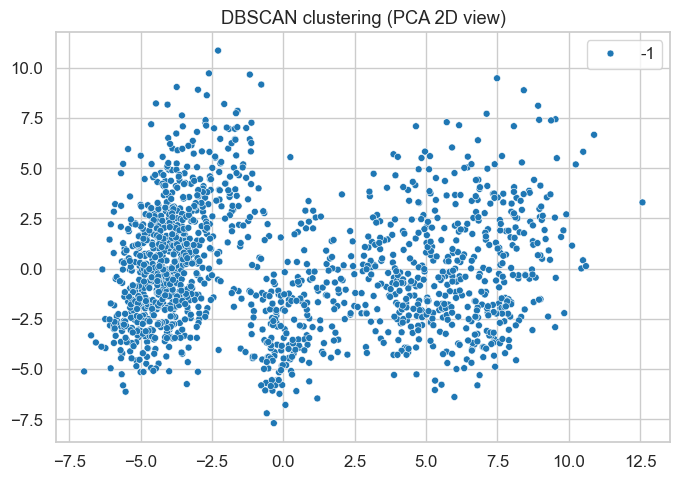

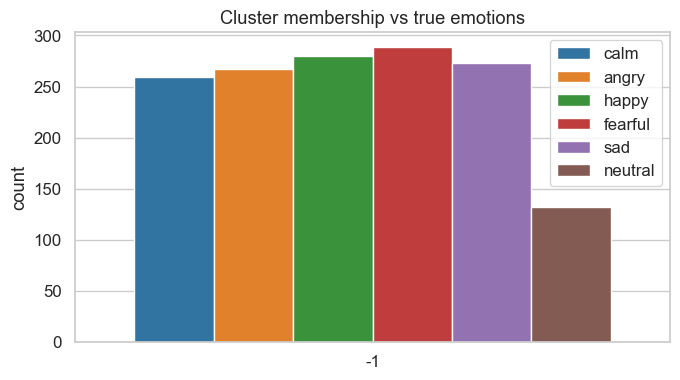

Saved DBSCAN visualization data to: C:\Users\User\Desktop\ML_finalprojectfile\dbscan_vis.npz


In [7]:
# Cell 7: DBSCAN clustering on feature space (unsupervised)

# to keep runtime reasonable, subsample
sub_idx = np.random.choice(len(X), size=min(1500, len(X)), replace=False)
X_sub = X[sub_idx]
y_sub_em = y_emotion[sub_idx]

X_sub_s = scaler.transform(X_sub)

dbscan = DBSCAN(eps=1.5, min_samples=5)
clusters = dbscan.fit_predict(X_sub_s)

print("DBSCAN cluster labels:", np.unique(clusters))

# use PCA for 2D plotting
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_sub_s)

plt.figure(figsize=(7,5))
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=clusters, palette="tab10", s=25, legend="full"
)
plt.title("DBSCAN clustering (PCA 2D view)")
plt.tight_layout()
plt.show()

# optional: compare cluster id vs true emotions
plt.figure(figsize=(7,4))
sns.countplot(x=clusters, hue=y_sub_em, palette="tab10")
plt.title("Cluster membership vs true emotions")
plt.tight_layout()
plt.show()
# Save DBSCAN visualization data for the GUI
np.savez(
    DBSCAN_VIS_PATH,
    X_pca=X_pca,
    clusters=clusters,
    y_sub_em=y_sub_em,
)
print("Saved DBSCAN visualization data to:", DBSCAN_VIS_PATH)



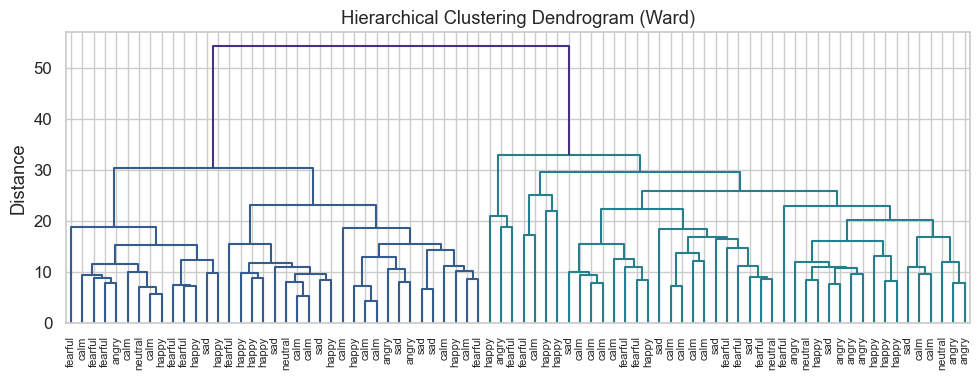

Saved hierarchical clustering data to: C:\Users\User\Desktop\ML_finalprojectfile\hierarchical_vis.npz


In [8]:
 # Cell 8: Hierarchical clustering dendrogram (small subset)

# choose small subset for dendrogram (too big becomes unreadable)
sub_idx2 = np.random.choice(len(X_sub_s), size=min(80, len(X_sub_s)), replace=False)
X_small = X_sub_s[sub_idx2]
labels_small = y_sub_em[sub_idx2]

Z = linkage(X_small, method="ward")

plt.figure(figsize=(10, 4))
dendrogram(
    Z,
    labels=labels_small,
    leaf_rotation=90,
    leaf_font_size=8,
    color_threshold=0.7 * np.max(Z[:,2])
)
plt.title("Hierarchical Clustering Dendrogram (Ward)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()
# Save hierarchical clustering data for the GUI
np.savez(
    HIER_VIS_PATH,
    Z=Z,
    labels_small=labels_small,
)
print("Saved hierarchical clustering data to:", HIER_VIS_PATH)
